In [51]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [2]:
import podspy.log, json
import itertools as itls

In [3]:
TRACE_STATS_ENRICHED_FILENAME = 'trace-stats-enriched.csv'
TRACE_STATS_FILENAME = 'trace-stats.csv'
CONFIGS_JSON_FILENAME = 'configs.json'
REPLAY_ID = 'replay_id'
ALIGNMENT_FILENAME = 'alignments.json'
ALIGNMENT_FPATH = 'alignment_fpath'
REPEAT_ID = 'repeat_id'

# things to ignore from configs
OUTFILE_KEY = 'outFile'
RESULTDIR_KEY = 'resultDir'
LOGPATH_KEY = 'logPath'
MODELPATH_KEY = 'modelPath'
TO_IGNORE_KEY_LIST = [
    OUTFILE_KEY,
    RESULTDIR_KEY,
    LOGPATH_KEY,
    MODELPATH_KEY
]

def mono_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_ENRICHED_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df


def reco_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df

### Inc3 results

In [11]:
inc3_basedir = '../../results-agg/clst_2019_01_net1_repeat_repacked/'
inc3_basedir_content = filter(lambda d: 'inc3' in d, os.listdir(inc3_basedir))
inc3_basedir_content = sorted(list(inc3_basedir_content))
is_mono = lambda d: 'mono' in d
is_sese = lambda d: 'sese' in d
is_mono_and_sese = lambda d: is_mono(d) and is_sese(d)
is_mono_and_gene = lambda d: is_mono(d) and 'gene' in d

mono_sese_inc3_dir_list = list(filter(is_mono_and_sese, inc3_basedir_content))
mono_gene_inc3_dir_list = list(filter(is_mono_and_gene, inc3_basedir_content))
reco_sese_inc3_dir_list = list(filter(lambda d: not is_mono(d) and is_sese(d), inc3_basedir_content))
reco_gene_inc3_dir_list = list(filter(lambda d: not is_mono(d) and not is_sese(d), inc3_basedir_content))


def read_trace_stats_df(dir_list, basedir, is_mono):
    df_list = []
    repeat_id = 0
    
    for d in dir_list:
        experiment_dirpath = os.path.join(basedir, d)
        
        for replay_dir in os.listdir(experiment_dirpath):
            replay_dirpath = os.path.join(experiment_dirpath, replay_dir)
            if not os.path.isdir(replay_dirpath):
                continue
            
            read_trace_stats_func = mono_read_trace_stats if is_mono else reco_read_trace_stats
            trace_stats_df = read_trace_stats_func(replay_dir, replay_dirpath)
            trace_stats_df[REPEAT_ID] = repeat_id
            df_list.append(trace_stats_df)
        
        repeat_id += 1
    
    return pd.concat(df_list, axis=0, sort=False)


mono_sese_inc3_stats_df = read_trace_stats_df(mono_sese_inc3_dir_list, inc3_basedir, True)
mono_gene_inc3_stats_df = read_trace_stats_df(mono_gene_inc3_dir_list, inc3_basedir, True)
reco_sese_inc3_stats_df = read_trace_stats_df(reco_sese_inc3_dir_list, inc3_basedir, False)
reco_gene_inc3_stats_df = read_trace_stats_df(reco_gene_inc3_dir_list, inc3_basedir, False)

In [18]:
mono_sese_inc3_trace_id_set = set(mono_sese_inc3_stats_df.loc[(mono_sese_inc3_stats_df['SP label'] != 'Empty'), 'SP label'])
reco_sese_inc3_trace_id_set = set(reco_sese_inc3_stats_df.loc[(reco_sese_inc3_stats_df['SP label'] != 'Empty'), 'SP label'])

mono_has = mono_sese_inc3_trace_id_set.difference(reco_sese_inc3_trace_id_set)
reco_has = reco_sese_inc3_trace_id_set.difference(mono_sese_inc3_trace_id_set)

### Plot important replay statistics across the 92 traces 

In [21]:
mono_sese_inc3_stats_df.head()

,SP label,Exit code for alignment,Length of the alignment found,Length of the orignal trace,Places in the synchronous product,Transtions in the synchronous product,Cost of the alignment,Transitions fired,Markings polled from queue,Markings added to closed set,...,queueSort,log,preferExact,printAlignments,partiallyOrderEvents,model,moveOnLogCosts,useInt,iteration,repeat_id
0,Empty,1,28,1,164,240,108,65,34,28,...,True,net1-10-60-l2000,True,True,False,net1,10,False,2,0
1,2249,34,0,377,542,994,0,15292,3820,3820,...,True,net1-10-60-l2000,True,True,False,net1,10,False,2,0
2,3815,34,118,98,263,436,430,10441,3256,3195,...,True,net1-10-60-l2000,True,True,False,net1,10,False,2,0
3,3942,34,0,149,314,538,0,14647,4583,4583,...,True,net1-10-60-l2000,True,True,False,net1,10,False,2,0
4,4056,34,87,103,268,446,246,9853,3092,2952,...,True,net1-10-60-l2000,True,True,False,net1,10,False,2,0


In [22]:
mono_sese_inc3_stats_df.columns

Index(['SP label', 'Exit code for alignment', 'Length of the alignment found',
       'Length of the orignal trace', 'Places in the synchronous product',
       'Transtions in the synchronous product', 'Cost of the alignment',
       'Transitions fired', 'Markings polled from queue',
       'Markings added to closed set', 'Markings queued', 'Markings reached',
       'Heuristics computed', 'Heuristics estimated', 'Heuristics derived',
       'Maximum queue length (elts)', 'Maximum queue capacity (elts)',
       'Maximum capacity visited set (elts)',
       'Approximate peak memory used (kb)', 'Time to compute alignment (us)',
       'Time to compute heuristics (us)', 'Time to setup algorithm (us)',
       'Total Time including setup (us)',
       'Number of splits when splitting marking', 'Log move cost of alignment',
       'Model move cost of alignment', 'Synchronous move cost of alignment',
       'Pre-processing time (us)', 'Size of the constraintset',
       'Number of times repla

#### Analyze if there are fluctuations in terms of alignment exit code

In [55]:
valid_mono_sese_inc3_stats_df.shape

(86, 62)

In [66]:
type(invalid_mono_grouped_df.loc[:,('Exit code for alignment', 'count')].values)

numpy.ndarray

Monolithic had 84 traces that had invalid alignments during the 5 experiments
Recomposing had 84 traces that had invalid alignments during the 5 experiments


''

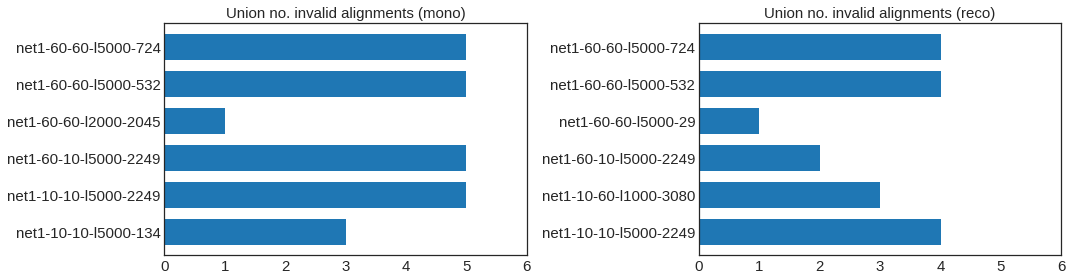

In [149]:
invalid_mono_sese_inc3_stats_df = mono_sese_inc3_stats_df[
    (mono_sese_inc3_stats_df['Exit code for alignment'] != 1)
]
invalid_reco_sese_inc3_stats_df = reco_sese_inc3_stats_df[
    (reco_sese_inc3_stats_df['Exit code for alignment'] != 1)
]
invalid_mono_sese_inc3_stats_df['_id'] = invalid_mono_sese_inc3_stats_df['log'] + '-' + invalid_mono_sese_inc3_stats_df['SP label']
invalid_reco_sese_inc3_stats_df['_id'] = invalid_reco_sese_inc3_stats_df['log'] + '-' + invalid_reco_sese_inc3_stats_df['SP label']

# groupby id
invalid_mono_grouped_df = invalid_mono_sese_inc3_stats_df[['_id', 'Exit code for alignment']].groupby('_id').agg(['count']).reset_index()
invalid_reco_grouped_df = invalid_reco_sese_inc3_stats_df[['_id', 'Exit code for alignment']].groupby('_id').agg(['count']).reset_index()

n_invalid_mono = invalid_mono_grouped_df['_id'].unique().shape[0]
n_invalid_reco = invalid_reco_grouped_df['_id'].unique().shape[0]

not_all_invalid_mono = invalid_mono_grouped_df[(invalid_mono_grouped_df[('Exit code for alignment', 'count')] < 5)]
not_all_invalid_reco = invalid_reco_grouped_df[(invalid_reco_grouped_df[('Exit code for alignment', 'count')] < 5)]
to_select_id = set(not_all_invalid_mono['_id'].values).union(not_all_invalid_reco['_id'].values)

# filter invalid mono_grouped df and reco_grouped df by to select ids
invalid_mono_grouped_df = invalid_mono_grouped_df[(invalid_mono_grouped_df['_id'].isin(to_select_id))]
invalid_reco_grouped_df = invalid_reco_grouped_df[(invalid_reco_grouped_df['_id'].isin(to_select_id))]

fig, axes = plt.subplots(figsize=(15, 4), ncols=2)
# fig, axes = plt.subplots(figsize=(15, 20), ncols=2)

# mono
xtick_labels_mono = invalid_mono_grouped_df.loc[:,'_id'].values
cnt_mono = invalid_mono_grouped_df.loc[:,('Exit code for alignment', 'count')].values
n_bars_mono = invalid_mono_grouped_df['_id'].unique().shape[0]
ind = np.arange(n_bars_mono)
width = 0.7

rects = axes[0].barh(ind, cnt_mono, width)
axes[0].set_yticks(ind)
axes[0].set_yticklabels(xtick_labels_mono)
axes[0].set_title('Union no. invalid alignments (mono)', fontsize=15)
axes[0].set_xlim([0, 6])

xtick_labels_reco = invalid_reco_grouped_df.loc[:,'_id'].values
cnt_reco = invalid_reco_grouped_df.loc[:,('Exit code for alignment', 'count')].values
n_bars_reco = invalid_reco_grouped_df['_id'].unique().shape[0]
ind = np.arange(n_bars_reco)
width = 0.7

rects = axes[1].barh(ind, cnt_reco, width)
axes[1].set_yticks(ind)
axes[1].set_yticklabels(xtick_labels_reco)
axes[1].set_title('Union no. invalid alignments (reco)', fontsize=15)
axes[1].set_xlim([0, 6])

fig.tight_layout()

print('Monolithic had {} traces that had invalid alignments during the 5 experiments'.format(n_invalid_mono))
print('Recomposing had {} traces that had invalid alignments during the 5 experiments'.format(n_invalid_reco))
;

For all the traces for which either the monolithic or the recomposing had <5 invalid alignments, i.e., some of experiments resulted in valid alignments, we plot their count.

#### Compute the rate of confusion matrix 

#### Compute how bad are the fluctuations amongst the valid alignments

In [123]:
reco_sese_inc3_stats_df.columns

Index(['SP label', 'Maximum queue capacity (elts)', 'Markings reached',
       'Log move cost of alignment', 'Heuristics derived',
       'Total Time including setup (us)', 'Heuristics estimated',
       'Size of the constraintset', 'Time to setup algorithm (us)',
       'Synchronous move cost of alignment', 'Maximum queue length (elts)',
       'Heuristics computed', 'Model move cost of alignment',
       'Time to compute heuristics (us)', 'Pre-processing time (us)',
       'Markings added to closed set', 'Markings polled from queue',
       'Markings queued', 'Transitions fired',
       'Maximum capacity visited set (elts)', 'Time to compute alignment (us)',
       'max Memory (MB)', 'total Memory (MB)', 'Cost of the alignment',
       'Exit code for alignment', 'Number of splits when splitting marking',
       'Number of times replay was restarted', 'merged_alignment_cost',
       'merged_alignment_length', 'merged_alignment_log_trace_length',
       'merged_alignment_model_trace_le

In [141]:
mono_sese_inc3_stats_df.columns

Index(['SP label', 'Exit code for alignment', 'Length of the alignment found',
       'Length of the orignal trace', 'Places in the synchronous product',
       'Transtions in the synchronous product', 'Cost of the alignment',
       'Transitions fired', 'Markings polled from queue',
       'Markings added to closed set', 'Markings queued', 'Markings reached',
       'Heuristics computed', 'Heuristics estimated', 'Heuristics derived',
       'Maximum queue length (elts)', 'Maximum queue capacity (elts)',
       'Maximum capacity visited set (elts)',
       'Approximate peak memory used (kb)', 'Time to compute alignment (us)',
       'Time to compute heuristics (us)', 'Time to setup algorithm (us)',
       'Total Time including setup (us)',
       'Number of splits when splitting marking', 'Log move cost of alignment',
       'Model move cost of alignment', 'Synchronous move cost of alignment',
       'Pre-processing time (us)', 'Size of the constraintset',
       'Number of times repla

In [136]:
# make time as seconds
valid_mono_sese_inc3_stats_df = mono_sese_inc3_stats_df[
    (mono_sese_inc3_stats_df['Exit code for alignment'] == 1)
    & (mono_sese_inc3_stats_df['SP label'] != 'Empty')
]
valid_reco_sese_inc3_stats_df = reco_sese_inc3_stats_df[
    (reco_sese_inc3_stats_df['Exit code for alignment'] == 1)
    & (reco_sese_inc3_stats_df['SP label'] != 'Empty')
]

valid_mono_sese_inc3_stats_df['Total Time including setup (us)'] /= 1000000
valid_mono_sese_inc3_stats_df['Time to compute alignment (us)'] /= 1000000
valid_mono_sese_inc3_stats_df['Time to compute heuristics (us)'] /= 1000000

valid_reco_sese_inc3_stats_df['Total Time including setup (us)'] /= 1000000
valid_reco_sese_inc3_stats_df['Time to compute alignment (us)'] /= 1000000
valid_reco_sese_inc3_stats_df['Time to compute heuristics (us)'] /= 1000000

num_mono_sese_inc3_stats_df = valid_mono_sese_inc3_stats_df.set_index(['SP label', 'log']).select_dtypes(include=[np.number]).reset_index(drop=False)
num_reco_sese_inc3_stats_df = valid_reco_sese_inc3_stats_df.set_index(['SP label', 'log']).select_dtypes(include=[np.number]).reset_index(drop=False)

# compute means and std
unique_cnt_func = lambda vals: len(set(vals))
unique_cnt_func.__name__ = 'unique_cnt'
num_mono_grouped_df = num_mono_sese_inc3_stats_df.groupby(['log', 'SP label']).agg(['mean', 'std', 'count', unique_cnt_func])
num_reco_grouped_df = num_reco_sese_inc3_stats_df.groupby(['log', 'SP label']).agg(['mean', 'std', 'count', unique_cnt_func])

num_reco_grouped_df.loc[:,['merged_alignment_length', 'merged_alignment_cost', 'Time to compute alignment (us)', 'Total Time including setup (us)', 'Markings polled from queue']]

Total Time including setup (us)                   \
                                                     mean        std count   
log              SP label                                                    
net1-10-10-l5000 134                           100.772209   6.730610     5   
                 2249                           31.463491        NaN     1   
net1-10-60-l1000 1958                           89.584258  10.588560     5   
                 3080                          135.542344   1.266519     2   
net1-10-60-l2000 4488                          110.495070   5.920977     5   
net1-60-10-l5000 2249                           28.370163   3.635998     3   
                 3890                           30.711615   1.354954     5   
                 4656                            0.739425   0.305236     5   
net1-60-60-l2000 2045                          265.719412  12.400591     5   
net1-60-60-l5000 1338                          143.538648  11.081933     5   
                 29                            280.776788  13.876308     4   
                 3868                           84.187324  10.216886     5   
                 532                           283.556122        NaN     1   
                 724                           299.975752        NaN     1   

                                     Markings polled from queue              \
                          unique_cnt                       mean         std   
log              SP label                                                     
net1-10-10-l5000 134             5.0               20204.800000  562.921131   
                 2249            1.0               14674.000000         NaN   
net1-10-60-l1000 1958            5.0                4974.000000  991.521810   
                 3080            2.0                5470.000000    0.000000   
net1-10-60-l2000 4488            5.0                6975.800000  170.744546   
net1-60-10-l5000 2249            3.0               14086.666667  679.206400   
                 3890            5.0                1783.400000   48.490205   
                 4656            5.0                1099.600000   65.748004   
net1-60-60-l2000 2045            5.0                8229.800000   80.939484   
net1-60-60-l5000 1338            5.0                1329.000000   31.200962   
                 29              4.0               10413.000000  163.378905   
                 3868            5.0                7227.200000  179.843543   
                 532             1.0               11712.000000         NaN   
                 724             1.0               10030.000000         NaN   

                                           Time to compute alignment (us)  \
                          count unique_cnt                           mean   
log              SP label                                                   
net1-10-10-l5000 134          5          5                     100.764779   
                 2249         1          1                      31.459977   
net1-10-60-l1000 1958         5          5                      89.582218   
                 3080         2          1                     135.540403   
net1-10-60-l2000 4488         5          5                     110.492939   
net1-60-10-l5000 2249         3          3                      28.365991   
                 3890         5          4                      30.709129   
                 4656         5          4                       0.736826   
net1-60-60-l2000 2045         5          5                     265.717655   
net1-60-60-l5000 1338         5          4                     143.537284   
                 29           4          4                     280.775145   
                 3868         5          5                      84.185910   
                 532          1          1                     283.554729   
                 724          1          1                     299.974179   

                                             

In [146]:
num_mono_grouped_df.loc[:,[ 'Time to compute alignment (us)', 'Total Time including setup (us)', 'Markings polled from queue', 'Cost of the alignment', 'Length of the alignment found']]

Length of the alignment found                        \
                                                   mean  std count unique_cnt   
log              SP label                                                       
net1-10-10-l5000 134                                360  0.0     2          1   
net1-10-60-l1000 1958                               160  0.0     5          1   
                 3080                               186  0.0     5          1   
net1-10-60-l2000 4488                               144  0.0     5          1   
net1-60-10-l5000 3890                               122  0.0     5          1   
                 4656                               128  0.0     5          1   
net1-60-60-l2000 2045                               213  0.0     4          1   
net1-60-60-l5000 1338                                84  0.0     5          1   
                 29                                 228  0.0     5          1   
                 3868                               216  0.0     5          1   

                          Cost of the alignment                        \
                                           mean  std count unique_cnt   
log              SP label                                               
net1-10-10-l5000 134                        374  0.0     2          1   
net1-10-60-l1000 1958                       678  0.0     5          1   
                 3080                       794  0.0     5          1   
net1-10-60-l2000 4488                       706  0.0     5          1   
net1-60-10-l5000 3890                       184  0.0     5          1   
                 4656                       146  0.0     5          1   
net1-60-60-l2000 2045                       838  0.0     4          1   
net1-60-60-l5000 1338                       412  0.0     5          1   
                 29                         960  0.0     5          1   
                 3868                       740  0.0     5          1   

                          Markings polled from queue                    \
                                                mean         std count   
log              SP label                                                
net1-10-10-l5000 134                          5827.5  217.081782     2   
net1-10-60-l1000 1958                         4030.8   47.060599     5   
                 3080                         4318.2   13.627179     5   
net1-10-60-l2000 4488                         3062.0   95.055247     5   
net1-60-10-l5000 3890                          909.4   79.156806     5   
                 4656                          713.0    0.000000     5   
net1-60-60-l2000 2045                         6372.5  183.638231     4   
net1-60-60-l5000 1338                         1056.0   27.910571     5   
                 29                           8087.8  223.212231     5   
                 3868                         5108.0  195.538999     5   

                                     Time to compute alignment (us)  \
                          unique_cnt                           mean   
log              SP label                                             
net1-10-10-l5000 134               2                      56.687012   
net1-10-60-l1000 1958              4                      82.880766   
                 3080              4                     121.751403   
net1-10-60-l2000 4488              4                      47.241337   
net1-60-10-l5000 3890              2                       3.725365   
                 4656              1                       1.881738   
net1-60-60-l2000 2045              4                     263.408400   
net1-60-60-l5000 1338              5                     138.886067   
                 29                5                     262.783979   
                 3868              5                      67.324291   

                                                       \
                                 std count unique_cnt   
log              SP l

#### The standard deviation in the standard deviation of total time